In [67]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator

In [68]:
batch_size = 32
img_height = 180
img_width = 180
DATA_DIR = "../chest_Xray/"
TEST = "test/"
TRAIN = "train/"
VAL = "val/"
NORMAL = "NORMAL"
PNEUMONIA = "PNEUMONIA"
NET = "NET"

In [69]:
# Créer un ensemble de données

train_ds = tf.keras.utils.image_dataset_from_directory(
  DATA_DIR +  TRAIN,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
  DATA_DIR + VAL,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 5216 files belonging to 2 classes.
Using 4173 files for training.
Found 16 files belonging to 2 classes.
Using 3 files for validation.


In [70]:
class_names = train_ds.class_names
num_classes = len(class_names)
print(class_names)

['NORMAL', 'PNEUMONIA']


In [71]:
# Configurer l'ensemble de données pour les performances

AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [72]:
# Standardiser les données

normalization_layer = tf.keras.layers.Rescaling(1./255)

normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 0.99960786


In [73]:
# Augmentation des données

data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

In [74]:
# cree le modele

model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [75]:
# Compiler le modèle

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [76]:
# Résumé du modèle

model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_6 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_7 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_9 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 45, 45, 32)       0         
 g2D)                                                 

In [77]:
# Create a callback allowing to save the best performing model
checkpoint = ModelCheckpoint("saved_model.model.h5", monitor='val_loss', verbose=1, save_best_only=True, min_delta = .002)

In [78]:
# Former le modèle
epochs=30
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  steps_per_epoch=300,
  callbacks=[checkpoint]
)

Epoch 1/20
131/131 [==============================] - ETA: 0s - loss: 0.4738 - accuracy: 0.7850
Epoch 1: val_loss improved from inf to 0.21141, saving model to saved_model.model.h5
131/131 [==============================] - 30s 222ms/step - loss: 0.4738 - accuracy: 0.7850 - val_loss: 0.2114 - val_accuracy: 1.0000
Epoch 2/20
131/131 [==============================] - ETA: 0s - loss: 0.2649 - accuracy: 0.8888
Epoch 2: val_loss did not improve from 0.21141
131/131 [==============================] - 29s 223ms/step - loss: 0.2649 - accuracy: 0.8888 - val_loss: 0.2898 - val_accuracy: 1.0000
Epoch 3/20
131/131 [==============================] - ETA: 0s - loss: 0.2587 - accuracy: 0.8962
Epoch 3: val_loss did not improve from 0.21141
131/131 [==============================] - 29s 220ms/step - loss: 0.2587 - accuracy: 0.8962 - val_loss: 0.6069 - val_accuracy: 0.6667
Epoch 4/20
131/131 [==============================] - ETA: 0s - loss: 0.1950 - accuracy: 0.9224
Epoch 4: val_loss did not improve f

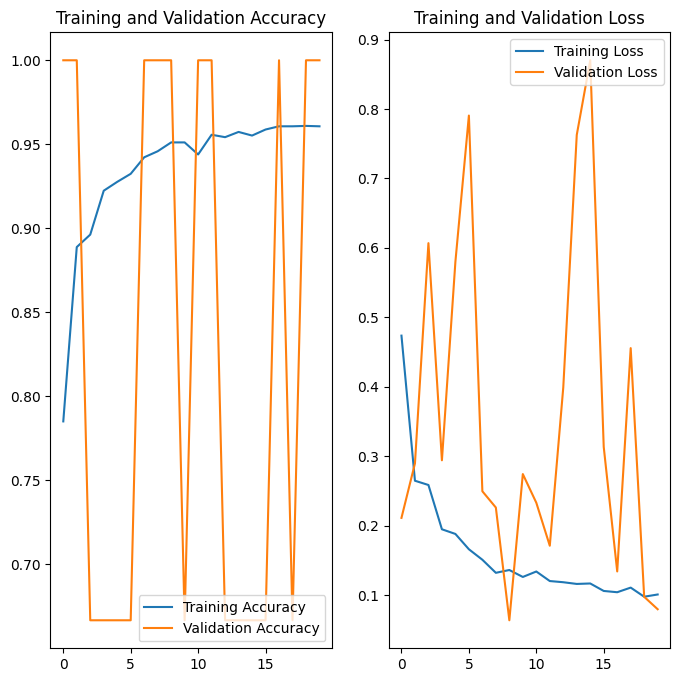

In [79]:
# Visualisez les résultats de l'entraînement

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [80]:
# test 
import os
  
  
for file in os.listdir(DATA_DIR + VAL + "/" + PNEUMONIA):
  img = tf.keras.utils.load_img(
      DATA_DIR + VAL + "/" + PNEUMONIA + "/" +file, target_size=(img_height, img_width)
  )
  img_array = tf.keras.utils.img_to_array(img)
  img_array = tf.expand_dims(img_array, 0)

  predictions = model.predict(img_array)
  score = tf.nn.softmax(predictions[0])

  print(
      "This image most likely belongs to {} with a {:.2f} percent confidence."
      .format(class_names[np.argmax(score)], 100 * np.max(score))
  )
  
for file in os.listdir(DATA_DIR + VAL + "/" + NORMAL):
  img = tf.keras.utils.load_img(
      DATA_DIR + VAL + "/" + NORMAL + "/" +file, target_size=(img_height, img_width)
  )
  img_array = tf.keras.utils.img_to_array(img)
  img_array = tf.expand_dims(img_array, 0)

  predictions = model.predict(img_array)
  score = tf.nn.softmax(predictions[0])

  print(
      "This image most likely belongs to {} with a {:.2f} percent confidence."
      .format(class_names[np.argmax(score)], 100 * np.max(score))
  )

1/1 [==============================] - 0s 53ms/step
This image most likely belongs to PNEUMONIA with a 99.97 percent confidence.
1/1 [==============================] - 0s 16ms/step
This image most likely belongs to PNEUMONIA with a 99.72 percent confidence.
1/1 [==============================] - 0s 16ms/step
This image most likely belongs to PNEUMONIA with a 98.64 percent confidence.
1/1 [==============================] - 0s 16ms/step
This image most likely belongs to PNEUMONIA with a 82.60 percent confidence.
1/1 [==============================] - 0s 17ms/step
This image most likely belongs to PNEUMONIA with a 76.59 percent confidence.
1/1 [==============================] - 0s 16ms/step
This image most likely belongs to PNEUMONIA with a 99.77 percent confidence.
1/1 [==============================] - 0s 17ms/step
This image most likely belongs to PNEUMONIA with a 94.01 percent confidence.
1/1 [==============================] - 0s 17ms/step
This image most likely belongs to PNEUMONIA w